In [23]:
## Version
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0
torch:  1.10 ; cuda:  1.10.0
detectron2: 0.6


In [24]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt


from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [25]:
## importation of all the image in the following folder
folder_path = "../images/5"
image_files = []
for file_name in os.listdir(folder_path):
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(folder_path, file_name)
        im = cv2.imread(file_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        image_files.append(im)

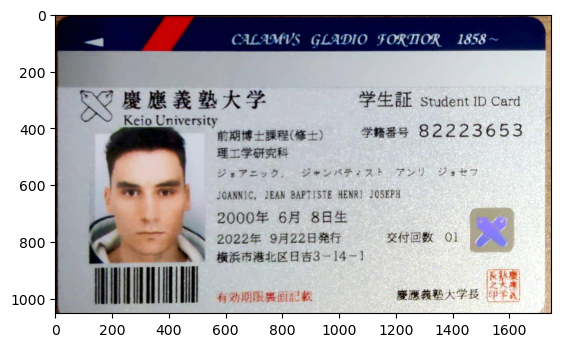

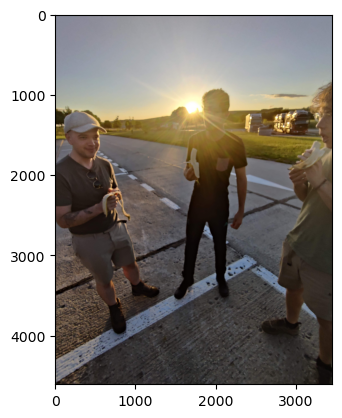

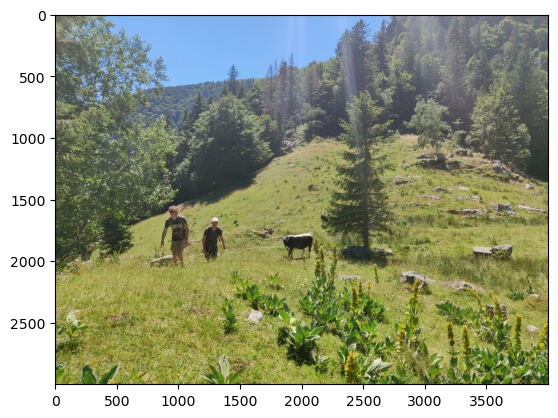

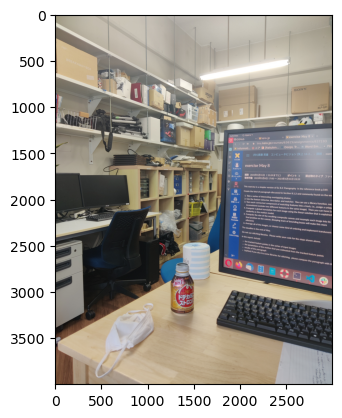

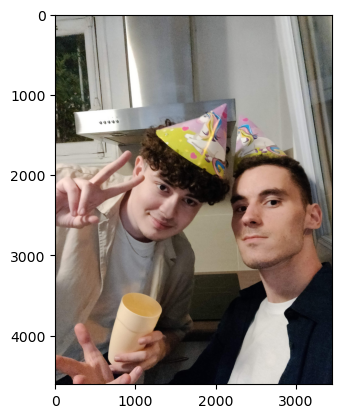

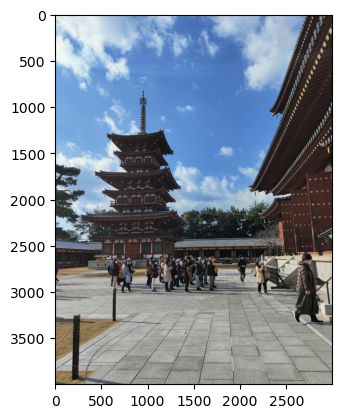

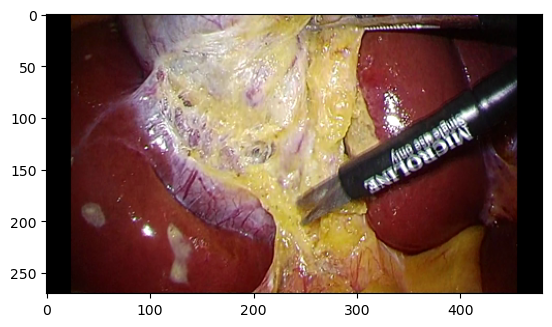

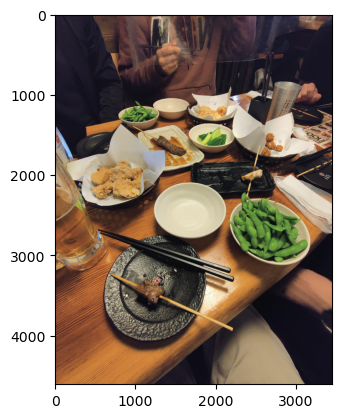

In [26]:
## display images
for im in image_files:
    plt.imshow(im)
    plt.show()

In [27]:
## model to detect only boxes

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

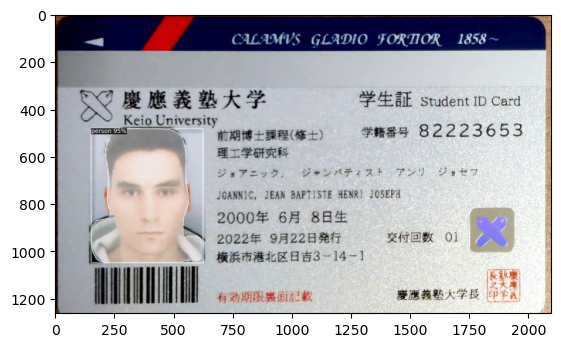

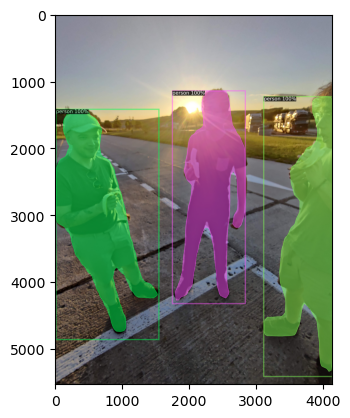

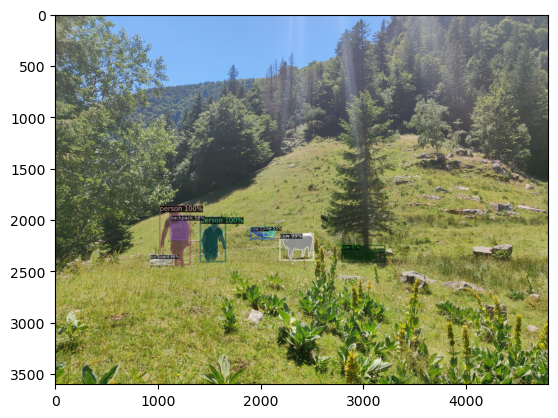

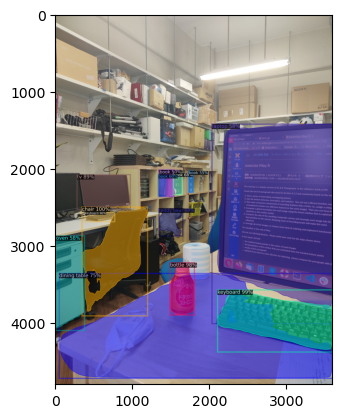

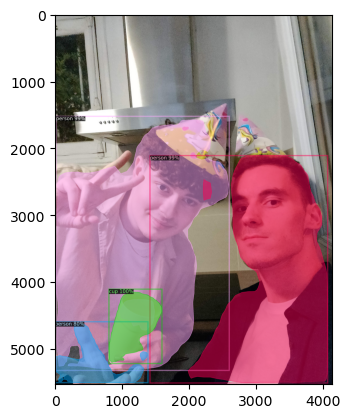

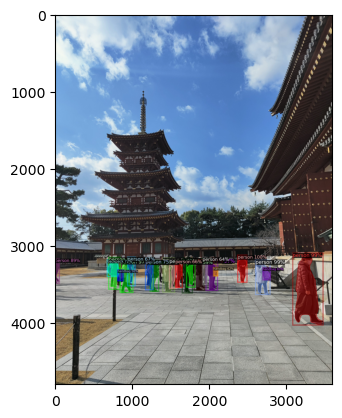

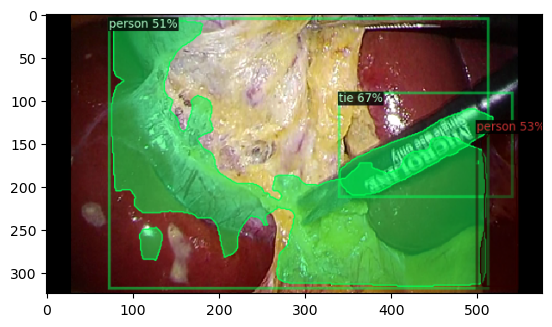

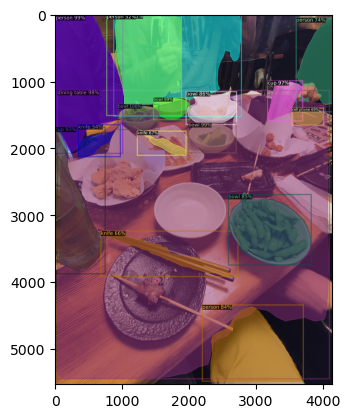

In [28]:
## detect and save results
for i,im in enumerate(image_files):
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    out = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGB2BGR)
    cv2.imwrite("../images/5/results/" + str(i) + "obj.jpg",out)

# comments
- We can see that the results are quite impressive when it comes to photos from everyday situations: for example, the model is very good at recognizing people, whether near or far (as in the photo with the temple). Even most obstructed people are recognized. So this is probably the class that has been trained the most, and with which the possibilities are the greatest. This is less the case for other classes that might be described as rarer. Like the cows in the mountain photo, the surrounding rocks are also recognized as rocks. One problem is that the model is far from labeling all objects; for example, the photo of the restaurant shows that some bowls are counted, but not all (even though their appearance doesn't differ all that much at a glance). What's more, due to the limited number of recognizable classes, some objects are labeled by probably the most similar class (e.g. skewers are recognized as chopsticks). This is all the more obvious when the image is totally different from the images the network has trained on. I tried putting in a frame from an endoscopic video, and it's clear that the model simply doesn't know what's being displayed, and doesn't even segment objects in the right way! 

- This is due to the fact that this model was trained on the COCO dataset, which contains many photos of everyday life, but no photos of very special situations, with rare everyday objects. In fact, there's a kind of linear relationship between the fact that the model says that an object belongs to a class, and the frequency with which we're confronted with this object on a daily basis.



In [29]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)


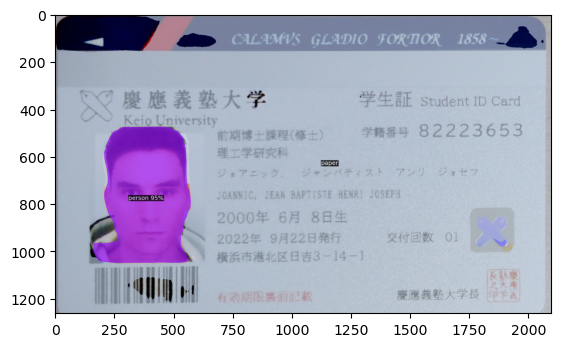

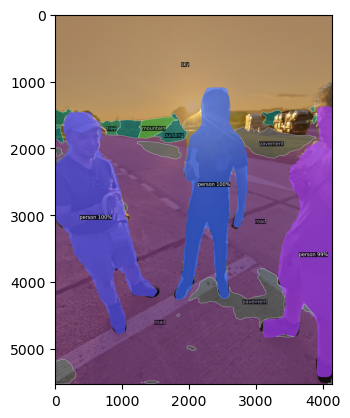

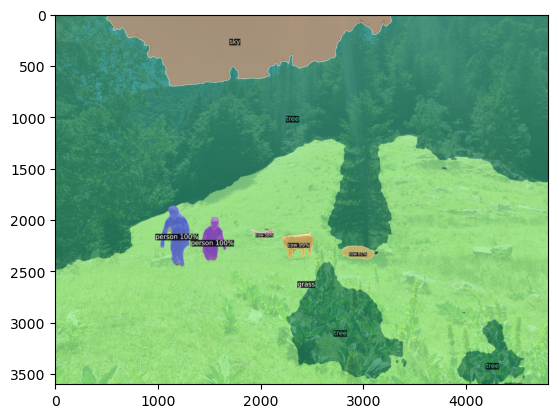

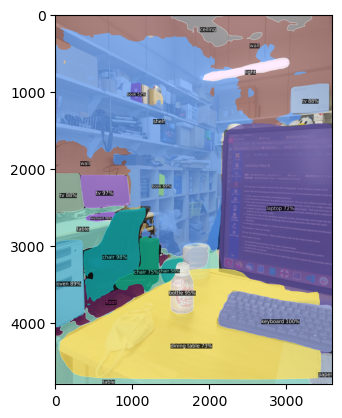

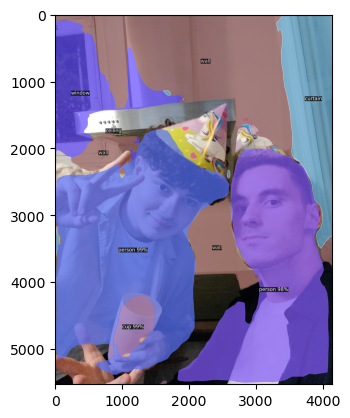

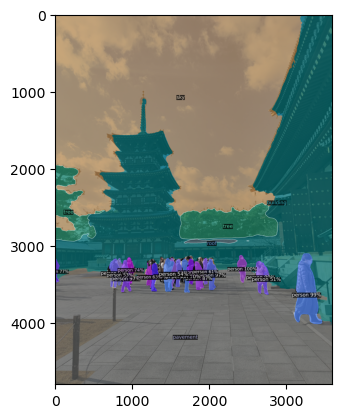

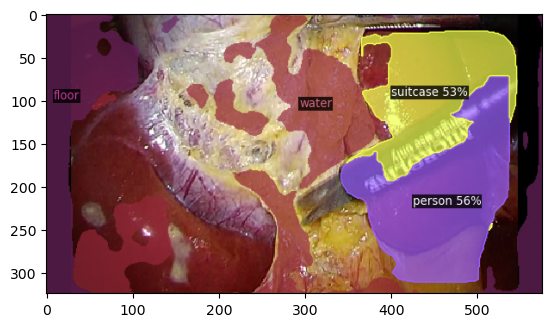

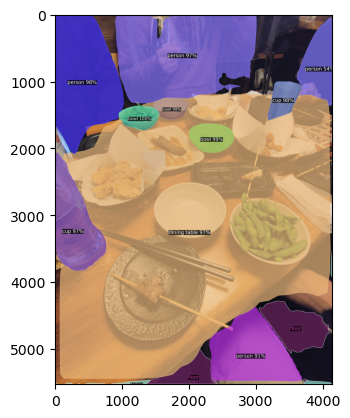

In [30]:
for i,im in enumerate(image_files):
    panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
    out = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGB2BGR)
    cv2.imwrite("../images/5/results/" + str(i) + "zone.jpg", out)

# comments
- I wanted to test another model which here tries to segment the whole image into several classes (instead of recognizing certain objects). I find that the results are better, but this is probably due to the fact that there seem to be more classes available (such as classes that are usually difficult to assign to objects that fall entirely within the camera's field of view, like a wall or the sky).
- We can make more or less the same points as for the other model, now that the bulk of the objects that weren't detected (like the bowls on the dining table, or the books on the laboratory shelf), are nevertheless included in more general classes (here dining table, and shelf). Which, while not perfect, is nonetheless more satisfying. One problem I've noticed is that the borders of segmented zones are very random, with elements often not included in the zone (e.g. the screen in the lab isn't in a perfectly rectangular zone, even though it stands out from the background). It is therefore necessary to rework the results a posteriori, with simpler segmentation tools if they are to be used.

- Just to talk quickly about performance, the 8-image test took me around 22 seconds for both models, despite the use of cuda. However, the pc in my lab has had some slowdowns lately, so it's possible that the time is not due to the model!
- Despite a few shortcomings, especially in very specific photos, the model remains powerful and accurate, especially if the results are not used as is. This just goes to show how important it is to carefully process the photos used to train the neural network.